# Detection with SSD

In this example, we will load a SSD model and use it to detect objects.

### 1. Setup

* First, Load necessary libs and set up caffe and caffe_root

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams.update({'font.size': 14})


# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import os
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')

()
import caffe
caffe.set_mode_gpu()
caffe.set_device(0)
#caffe.set_mode_cpu()

* Load LabelMap.

In [2]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
voc_labelmap_file = 'data/3Dpascal/pascal3D/labelmap_3D.prototxt'
file = open(voc_labelmap_file, 'r')
voc_labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), voc_labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

* Load the net in the test phase for inference, and configure input preprocessing.

In [3]:
model_def = 'models/VGGNet/Pascal3D/SSD_seperate_pose_bins=8_diff=False_numPascal=5_size=300_lr=0.000040_samp=False/\
deploy.prototxt'
model_weights = 'models/VGGNet/Pascal3D/SSD_seperate_pose_bins=8_diff=False_numPascal=5_size=300_lr=0.000040_samp=False/\
VGG_Pascal3D_SSD_seperate_pose_bins=8_diff=False_numPascal=5_size=300_lr=0.000040_samp=False_iter_45138.caffemodel'



net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

### 2. SSD detection

* Load an image.

CPU times: user 30.7 ms, sys: 59.7 ms, total: 90.4 ms
Wall time: 56.3 ms


/playpen/poirson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


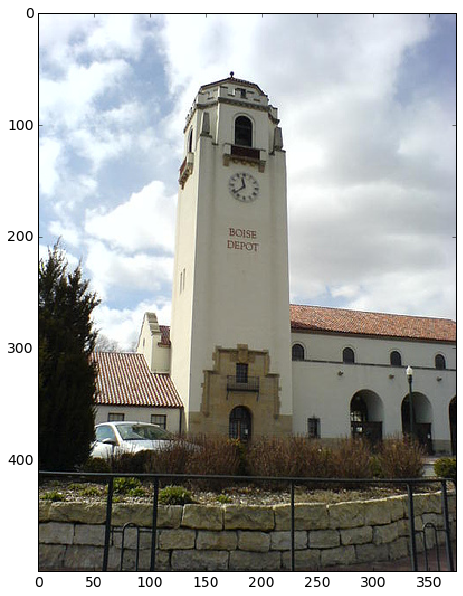

In [5]:
import json
import os.path as osp

valFile = open('data/3Dpascal/pascal3D/cache/train_bins=8_diff=False_imgnet=False_numPascal=1/train.txt', 'r')
basePath = 'data/3Dpascal/pascal3D/'

val = [line.rstrip('\n').split(' ') for line in valFile]
valPair = val[np.random.choice(len(val), 1)]

imfile = osp.join(basePath, valPair[0])
annfile = osp.join(basePath, valPair[1])

ann = json.load(open(annfile, 'r'))
gtpose = ann['annotation'][0]['aziLabel']
    

# set net to batch size of 1
image_resize = 300
net.blobs['data'].reshape(1,3,image_resize,image_resize)

image = caffe.io.load_image(imfile)
plt.imshow(image)


transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[...] = transformed_image

# Forward pass.
%time detections = net.forward()['detection_out']

# Parse the outputs.
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]
det_pose = detections[0, 0, :, 7]
det_poseScore = detections[0,0,:,8]

#print(det_pose)
#print(det_poseScore)

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.4]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
#print top_label_indices
top_labels = get_labelname(voc_labelmap, top_label_indices)
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]
top_pose = det_pose[top_indices]
top_poseScore = det_poseScore[top_indices]

#print det_conf
#print det_conf.shape
#print det_ymax.shape
#print det_pose.shape

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.imshow(image)
currentAxis = plt.gca()

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    score = top_conf[i]
    label = top_labels[i]
    pose = top_pose[i]
    pose_score = top_poseScore[i]
    name = '%s: %.2f, predicted pose = %d(%.2f), gt = %d'%(label, score, int(pose), pose_score, gtpose)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[i % len(colors)]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, name, bbox={'facecolor':'white', 'alpha':0.4})